# Cellpose

## Usage

- img restoration
  - denoising
  - deblurring
  - upsampling
- 3d cell segmentation (needs a stack of images)
- optimization for our own data

## Requirements(Installation)

```
conda create --name cell python=3.8
conda activate cell
python -m pip install cellpose
```

### Optional

if gui is needed:

```
python -m pip install cellpose[gui]
```

for zsh

```
python -m pip install 'cellpose[gui]'
```


## 2D model

### Latest model test


In [1]:
# chose a region of interest
from PIL import Image
image = Image.open("../sample_img/original_image_000001.tiff")
box = (100, 100, 800, 800)
cropped_image = image.crop(box)
cropped_image.save('../sample_img/cropped_example.tiff')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread

io.logger_setup()

# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model = models.Cellpose(model_type='cyto3')  # add gpu=True if you have a GPU

# list of files
# PUT PATH TO YOUR FILES HERE!
files = ['../sample_img/cropped_example.tiff']

imgs = [imread(f) for f in files]
nimg = len(imgs)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0, 0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(
    imgs, diameter=None, channels=channels)

2024-05-02 21:59:58,520 [INFO] WRITING LOG OUTPUT TO /home/telegraphpolehead/.cellpose/run.log
2024-05-02 21:59:58,523 [INFO] 
cellpose version: 	3.0.7 
platform:       	linux 
python version: 	3.8.19 
torch version:  	2.2.1+cpu
2024-05-02 21:59:58,524 [INFO] >>>> using CPU
2024-05-02 21:59:58,525 [INFO] >> cyto3 << model set to be used
2024-05-02 21:59:58,751 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-05-02 21:59:58,765 [INFO] channels set to [[0, 0]]
2024-05-02 21:59:58,766 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-05-02 22:00:05,421 [INFO] estimated cell diameter(s) in 6.65 sec
2024-05-02 22:00:05,422 [INFO] >>> diameter(s) = 
2024-05-02 22:00:05,422 [INFO] [19.25, ]
2024-05-02 22:00:05,423 [INFO] ~~~ FINDING MASKS ~~~
2024-05-02 22:00:10,828 [INFO] >>>> TOTAL TIME 12.06 sec


In [3]:
# SAVE RESULTS
filename = files
img = imgs[0]
io.masks_flows_to_seg(img, masks, flows, diams, filename, channels)
io.save_to_png(img, masks, flows, filename)

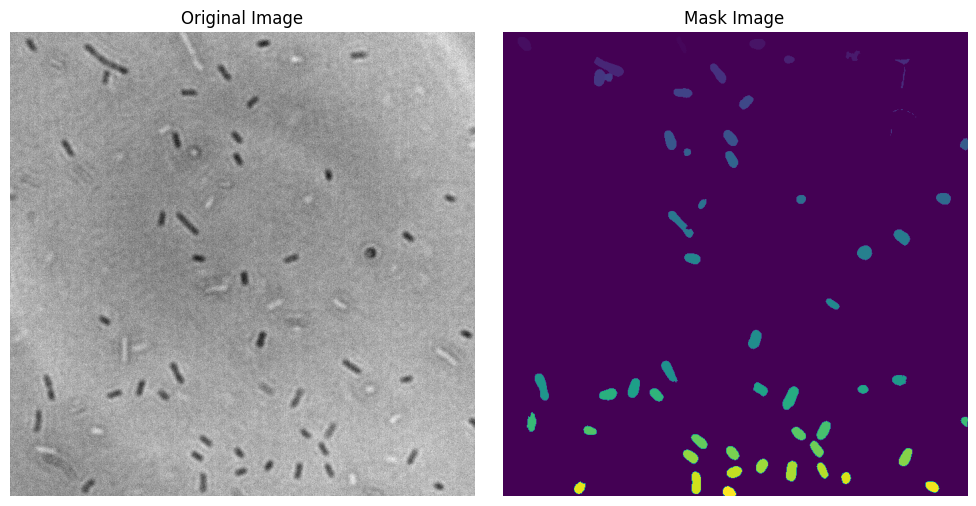

In [6]:
mask_img = imread("../sample_img/cropped_example_cp_masks.png")
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(mask_img)
plt.axis('off')
plt.title('Mask Image')

plt.tight_layout()
plt.show()

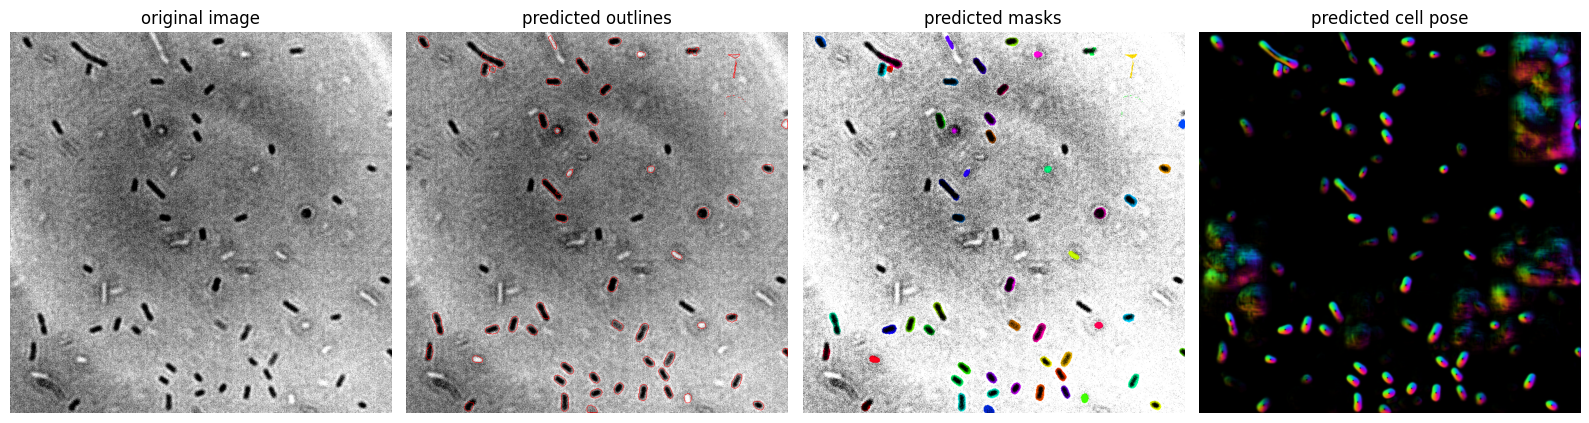

In [5]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(16, 8))
plot.show_segmentation(fig, img, masks[0], flows[0][0])
plt.tight_layout()
plt.show()

> ### Problems:
>
> - not identify some **light** cells in the image
>   - retrain?
> - some background patterns are misclassified as cells


### Image Restoration

There are two main classes, `DenoiseModel` for image restoration only, and `CellposeDenoiseModel` for image restoration and then segmentation.


In [8]:
from cellpose import denoise
model = denoise.CellposeDenoiseModel(
    model_type="cyto3", restore_type="denoise_cyto3")  # add gpu=True if you have a GPU

masks, flows, styles, imgs_dn = model.eval(imgs, channels=[0, 0])

2024-05-02 22:04:40,081 [INFO] >> denoise_cyto3 << model set to be used
2024-05-02 22:04:40,082 [INFO] >>>> using CPU
2024-05-02 22:04:40,258 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-05-02 22:04:40,260 [INFO] >> cyto3 << model set to be used
2024-05-02 22:04:40,260 [INFO] >>>> using CPU
2024-05-02 22:04:40,386 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


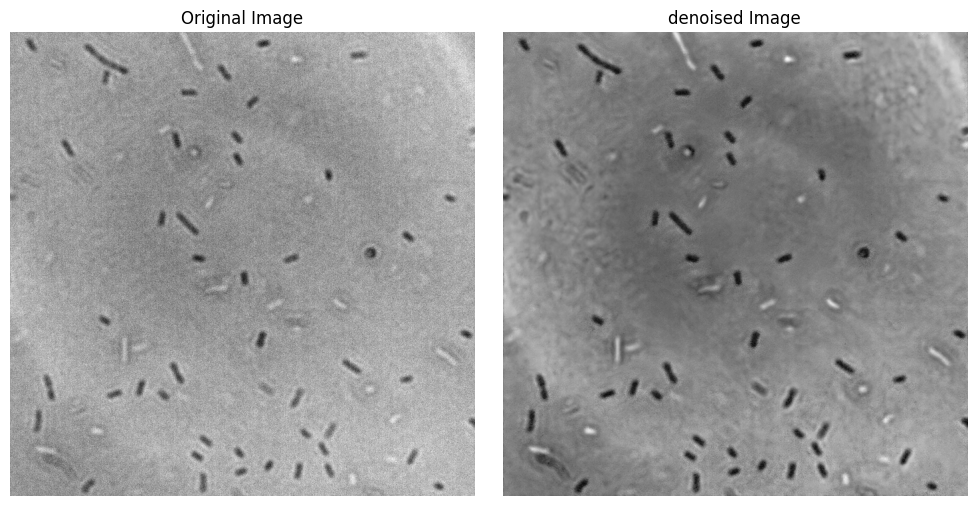

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(imgs_dn[0], cmap="gray")
plt.axis('off')
plt.title('denoised Image')

plt.tight_layout()
plt.show()

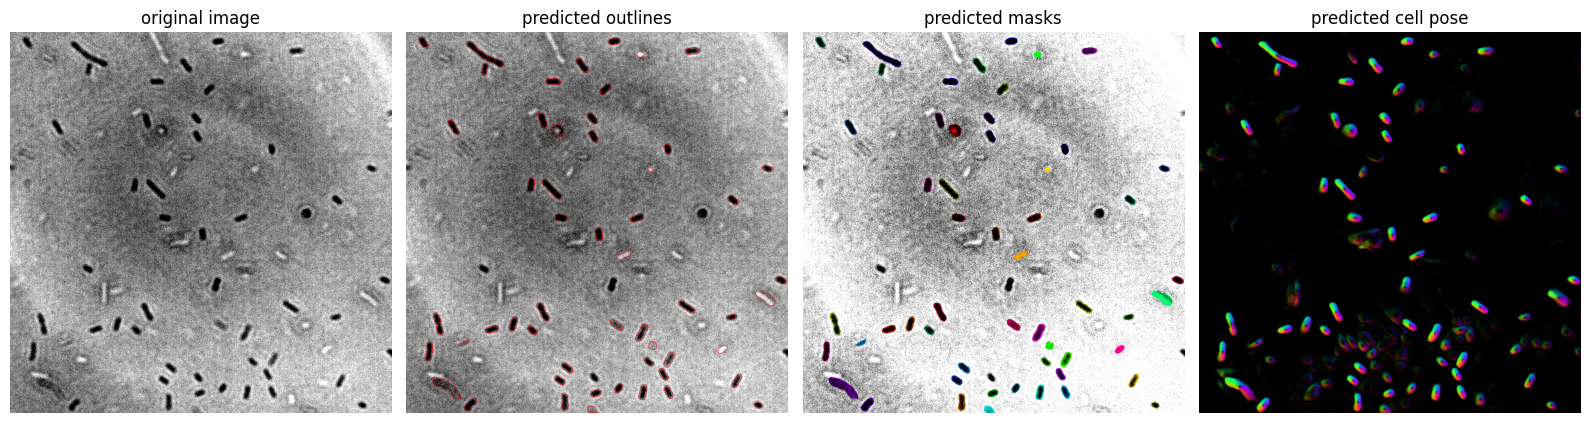

In [10]:
fig = plt.figure(figsize=(16, 8))
plot.show_segmentation(fig, img, masks[0], flows[0][0])
plt.tight_layout()
plt.show()

the results are improved.


### For filtered image

In [11]:

files = ['../sample_img/filtered_example2.tiff']

imgs_filtered = [imread(f) for f in files]

model = denoise.CellposeDenoiseModel(
    model_type="cyto3", restore_type="denoise_cyto3")  # add gpu=True if you have a GPU

masks, flows, styles, imgs_dn = model.eval(imgs_filtered, channels=[0, 0])

2024-05-02 22:14:28,326 [INFO] >> denoise_cyto3 << model set to be used
2024-05-02 22:14:28,327 [INFO] >>>> using CPU
2024-05-02 22:14:28,519 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-05-02 22:14:28,520 [INFO] >> cyto3 << model set to be used
2024-05-02 22:14:28,521 [INFO] >>>> using CPU
2024-05-02 22:14:28,689 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


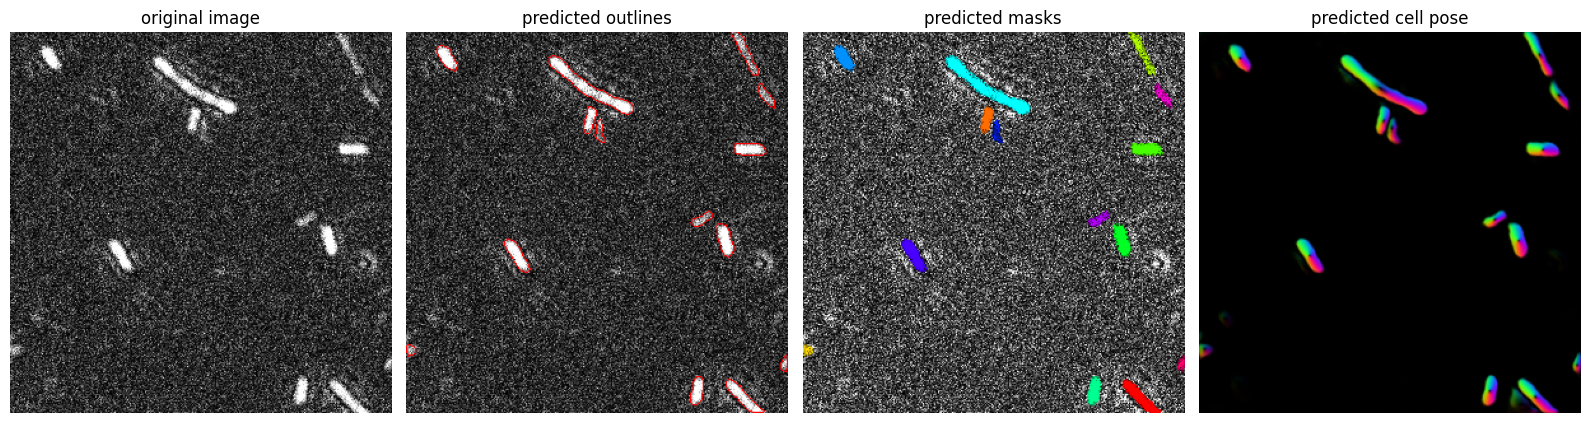

In [13]:
fig = plt.figure(figsize=(16, 8))
plot.show_segmentation(fig, imgs_filtered[0], masks[0], flows[0][0])
plt.tight_layout()
plt.show()

### Train

**TODO**:

- get more data and retrain the cellpose model


In [ ]:
from cellpose import io, models, train
io.logger_setup()

train_dir = ""
test_dir = ""

output = io.load_train_test_data(train_dir, test_dir, image_filter="_img",
                                 mask_filter="_masks", look_one_level_down=False)
images, labels, image_names, test_images, test_labels, image_names_test = output

# e.g. retrain a Cellpose model
model = models.CellposeModel(model_type="cyto3")

model_path = train.train_seg(model.net, train_data=images, train_labels=labels,
                             channels=[1, 2], normalize=True,
                             test_data=test_images, test_labels=test_labels,
                             weight_decay=1e-4, SGD=True, learning_rate=0.1,
                             n_epochs=100, model_name="my_new_model")

## 3D model

### Latest pre-trained model test

For multi-channel, multi-Z tiff's, the expected format is **Z x channels x Ly x Lx**
